In [1]:
# Import necessary libraries
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

# Set style for visualizations
plt.style.use('seaborn-v0_8')

In [2]:
# Load the dataset
data = pd.read_csv("employee_attendance_log.csv")
data.head()

,EmployeeID,Date,EntryTime,ExitTime,Department,Role
0,E001,2025-05-01,09:30,18:45,IT,Developer
1,E002,2025-05-01,10:30,18:30,Sales,Sales Manager
2,E003,2025-05-01,09:15,17:45,Finance,Financial Analyst
3,E004,2025-05-01,08:05,15:05,Finance,Financial Analyst
4,E005,2025-05-01,09:30,16:30,IT,Developer


In [3]:
# Convert date and time columns to datetime objects
data['Date'] = pd.to_datetime(data['Date'])
data['EntryTime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['EntryTime'])
data['ExitTime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['ExitTime'])

In [4]:
# Calculate working hours from entry and exit time
data['WorkingHours'] = (data['ExitTime'] - data['EntryTime']).dt.total_seconds() / 3600

In [5]:
data.head()

,EmployeeID,Date,EntryTime,ExitTime,Department,Role,WorkingHours
0,E001,2025-05-01,2025-05-01 09:30:00,2025-05-01 18:45:00,IT,Developer,9.25
1,E002,2025-05-01,2025-05-01 10:30:00,2025-05-01 18:30:00,Sales,Sales Manager,8.00
2,E003,2025-05-01,2025-05-01 09:15:00,2025-05-01 17:45:00,Finance,Financial Analyst,8.50
3,E004,2025-05-01,2025-05-01 08:05:00,2025-05-01 15:05:00,Finance,Financial Analyst,7.00
4,E005,2025-05-01,2025-05-01 09:30:00,2025-05-01 16:30:00,IT,Developer,7.00


In [6]:
# Calculate total working hours by week/month
def calculate_work_hours(data):
    """
    returns: Two Dataframes, one for weekly and one for monthly working hours
    """
    # Weekly working hours
    data_weekly = data.groupby([pd.Grouper(key='Date', freq='W-MON')])['WorkingHours'].sum().reset_index()
    data_weekly.rename(columns={'WorkingHours': 'TotalHours'}, inplace=True)

    # Monthly working hours
    data_monthly = data.groupby([pd.Grouper(key='Date', freq='M')])['WorkingHours'].sum().reset_index()
    data_monthly.rename(columns={'WorkingHours': 'TotalHours'}, inplace=True)

    return data_weekly, data_monthly

In [7]:
# Detects late arrivals and early exits based on expected times.
def detect_late_arrivals(data, expected_start_time='09:00:00'):
    # Convert expected start time to datetime for comparison
    data['ExpectedEntry'] = pd.to_datetime(data['Date'].astype(str) + ' ' + expected_start_time)
    
    # Detect late arrivals (after expected start time)
    late_arrivals = data[data['EntryTime'] > data['ExpectedEntry']].copy()
    late_arrivals['MinutesLate'] = (late_arrivals['EntryTime'] - late_arrivals['ExpectedEntry']).dt.total_seconds() / 60
    
    # For absence detection, we would need to compare against a complete list of expected employees
    # This is just a placeholder as we don't have that data in this example

    # Empty DataFrame as placeholder
    absences = pd.DataFrame(columns=data.columns)  
    
    return late_arrivals, absences

In [8]:
# Aggregate working hours by department and role
def group_by_department_role(data):
    """
    returns: two DataFrames by department and by role.
    """
    # Group by department
    by_department = data.groupby('Department')['WorkingHours'].sum().reset_index()
    by_department.rename(columns={'WorkingHours': 'TotalHours'}, inplace=True)
    
    # Group by role
    by_role = data.groupby('Role')['WorkingHours'].sum().reset_index()
    by_role.rename(columns={'WorkingHours': 'TotalHours'}, inplace=True)
    
    return by_department, by_role

In [9]:
# Calculate attendance rate per employee
def calculate_attendance_rate(data, total_days):
    """
    returns: DataFrame with attendance rate per employee
    """
    attendance = data.groupby('EmployeeID')['Date'].nunique().reset_index()
    attendance.rename(columns={'Date': 'DaysPresent'}, inplace=True)
    attendance['AttendanceRate(%)'] = (attendance['DaysPresent'] / total_days) * 100
    attendance['AttendanceRate(%)'] = attendance['AttendanceRate(%)'].round(2)
    return attendance

In [10]:
# Identify employees with the most frequent late arrivals
def top_late_employees(late_arrivals, top_n=10):
    """
    returns: DataFrame with the top N employees with the most late arrivals
    """
    late_counts = late_arrivals['EmployeeID'].value_counts().reset_index()
    late_counts.columns = ['EmployeeID', 'LateCount']
    return late_counts.head(top_n)

In [11]:
# Generate daily summary stats
def daily_summary(data):
    """
    returns: DataFrame with daily summary statistics including total employees and average working hours
    """
    summary = data.groupby('Date').agg(
        TotalEmployees=('EmployeeID', 'nunique'),
        AvgWorkingHours=('WorkingHours', 'mean')
    ).reset_index()
    summary['AvgWorkingHours'] = summary['AvgWorkingHours'].round(2)
    return summary

In [12]:
# Flag days with less than expected working hours
def flag_low_work_days(data, threshold=6):
    """
    returns: DataFrame with days where working hours are below the threshold
    """
    low_days = data[data['WorkingHours'] < threshold]
    return low_days[['EmployeeID', 'Date', 'WorkingHours']]

In [13]:
# Monthly working hours by department
def monthly_hours_by_department(data):
    """
    returns: DataFrame with monthly working hours by department and a bar plot visualization
    """
    data['Month'] = data['Date'].dt.to_period('M')
    monthly_dept = data.groupby(['Month', 'Department'])['WorkingHours'].sum().reset_index()
    pivot_table = monthly_dept.pivot(index='Month', columns='Department', values='WorkingHours').fillna(0)
    pivot_table.plot(kind='bar', stacked=True, figsize=(12,6))
    plt.title("Monthly Working Hours by Department")
    plt.ylabel("Total Hours")
    plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.legend(title="Department")
    plt.tight_layout()
    plt.show()
    return pivot_table


C:\Users\Usuario\AppData\Local\Temp\ipykernel_14680\1252142302.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = data.groupby([pd.Grouper(key='Date', freq='M')])['WorkingHours'].sum().reset_index()


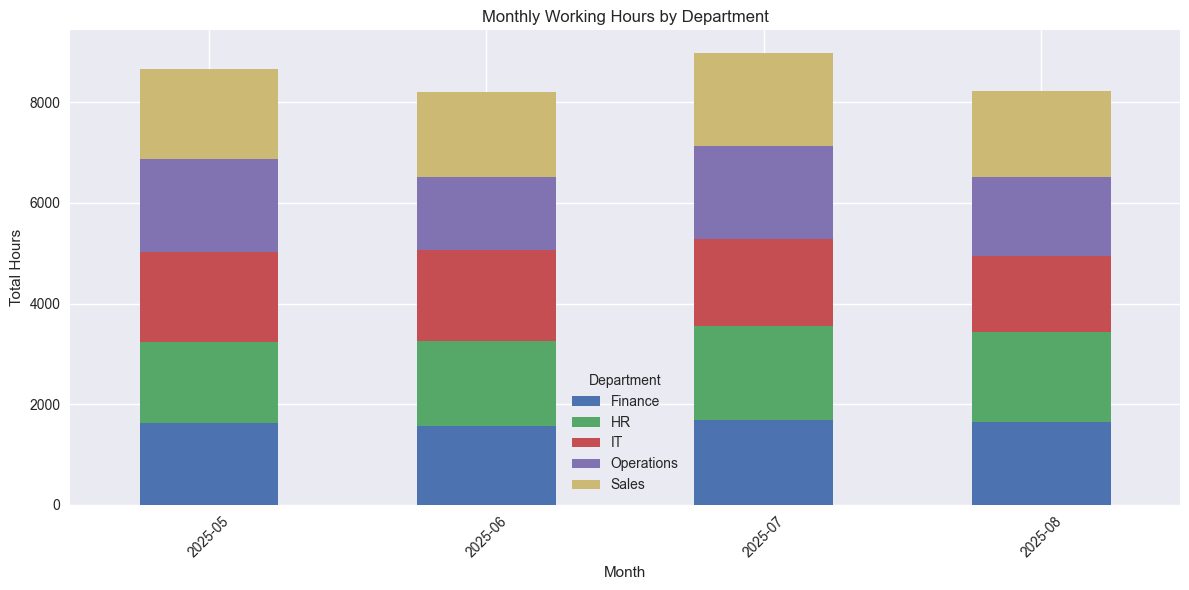

In [14]:
# Execute the analysis functions
weekly_hours, monthly_hours = calculate_work_hours(data)
late_arrivals, absences = detect_late_arrivals(data)
by_department, by_role = group_by_department_role(data)
attendance = calculate_attendance_rate(data, data['Date'].nunique())
top_late = top_late_employees(late_arrivals)
daily_stats = daily_summary(data)
low_work_days = flag_low_work_days(data)
monthly_dept_hours = monthly_hours_by_department(data)

In [15]:
# Export all key outputs to CSV reports
weekly_hours.to_csv("weekly_working_hours.csv", index=False)
monthly_hours.to_csv("monthly_working_hours.csv", index=False)
late_arrivals[['EmployeeID', 'Date', 'EntryTime', 'MinutesLate']].to_csv("late_arrivals.csv", index=False)
by_department.to_csv("working_hours_by_department.csv", index=False)
by_role.to_csv("working_hours_by_role.csv", index=False)
attendance.to_csv("attendance_rate_per_employee.csv", index=False)
top_late.to_csv("top_late_employees.csv", index=False)
daily_stats.to_csv("daily_summary.csv", index=False)
low_work_days.to_csv("low_working_days.csv", index=False)
monthly_dept_hours.to_csv("monthly_department_hours.csv")

In [16]:
# Define the total width for centering
WIDTH = 50

# Display results in organized sections
print("=" * WIDTH)
print("WEEKLY WORKING HOURS".center(WIDTH))
print("=" * WIDTH)
print(weekly_hours)

print("\n" + "=" * WIDTH)
print("MONTHLY WORKING HOURS".center(WIDTH))
print("=" * WIDTH)
print(monthly_hours)

print("\n" + "=" * WIDTH)
print("LATE ARRIVALS".center(WIDTH))
print("=" * WIDTH)
print(late_arrivals[['EmployeeID', 'Date', 'EntryTime', 'MinutesLate']])

print("\n" + "=" * WIDTH)
print("WORKING HOURS BY DEPARTMENT".center(WIDTH))
print("=" * WIDTH)
print(by_department)

print("\n" + "=" * WIDTH)
print("WORKING HOURS BY ROLE".center(WIDTH))
print("=" * WIDTH)
print(by_role)

print("\n" + "=" * WIDTH)
print("ATTENDANCE RATE PER EMPLOYEE".center(WIDTH))
print("=" * WIDTH)
print(attendance[['EmployeeID', 'DaysPresent', 'AttendanceRate(%)']])


               WEEKLY WORKING HOURS               
         Date  TotalHours
0  2025-05-05     1160.75
1  2025-05-12     2008.00
2  2025-05-19     1962.50
3  2025-05-26     1938.50
4  2025-06-02     1980.25
5  2025-06-09     1938.00
6  2025-06-16     1951.50
7  2025-06-23     1993.00
8  2025-06-30     1942.25
9  2025-07-07     1969.75
10 2025-07-14     1922.25
11 2025-07-21     1950.25
12 2025-07-28     1938.75
13 2025-08-04     1967.75
14 2025-08-11     1927.50
15 2025-08-18     1908.50
16 2025-08-25     2019.75
17 2025-09-01     1595.50

              MONTHLY WORKING HOURS               
        Date  TotalHours
0 2025-05-31     8667.75
1 2025-06-30     8207.00
2 2025-07-31     8978.50
3 2025-08-31     8221.50

                  LATE ARRIVALS                   
     EmployeeID       Date           EntryTime  MinutesLate
0          E001 2025-05-01 2025-05-01 09:30:00         30.0
1          E002 2025-05-01 2025-05-01 10:30:00         90.0
2          E003 2025-05-01 2025-05-01 09:15:00